In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy
from itertools import repeat
from IPython.display import clear_output

In [2]:
# Define rhoii0,rhoij0 distribution
def rhoij0(omega, Gamma, eta):
    Gi0=1/(omega+1.j*eta)
    Delta=np.full(len(omega),-1.j*Gamma)
    GM=np.array([[1/Gi0-Delta,-Delta],[-Delta,1/Gi0-Delta]])
    intGM=np.full((len(GM),len(GM),len(omega)), np.full((len(GM), len(omega)), np.zeros(len(omega),dtype = 'complex_')))
    for j in range(len(omega)):
        GM[:,:,j]=np.linalg.inv(GM[:,:,j])
    rhoM=-np.imag(GM)/np.pi
    rho=-np.imag(Gi0)/np.pi
    intG=np.zeros(len(omega),dtype = 'complex_')
    for j in tqdm(range(len(omega))):
        intG[j]=sum(-np.imag(Gi0[0:j])/np.pi)*((max(omega)-min(omega))/len(omega))
        for i in range(len(GM)):
            for k in range(len(GM)):
                intGM[i,k,j]=sum(rhoM[i,k,0:j])*((max(omega)-min(omega))/len(omega))
    return rhoM,intGM,GM,intG,rho

def find_nearest(array, value,omega):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return omega[idx],idx

def sampler(poles,intGM,posimp,omega):
    selected=np.full((len(posimp), poles), np.zeros(poles,dtype = 'complex_'))
    index=np.full((len(posimp), poles), np.zeros(poles,dtype = 'int_'))
    for k in range(len(selected)):
        for j in range(poles):
            x=np.random.randint(len(omega), size=poles)
            x2=np.linspace(min(intGM[k][k]),max(intGM[k][k]),len(omega))
            selected[k][j],index[k][j]=find_nearest(intGM[k][k], x2[x[j]],omega)
    return selected,index

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))  ###p[i]-1/2
    return Rho0, Rhoint

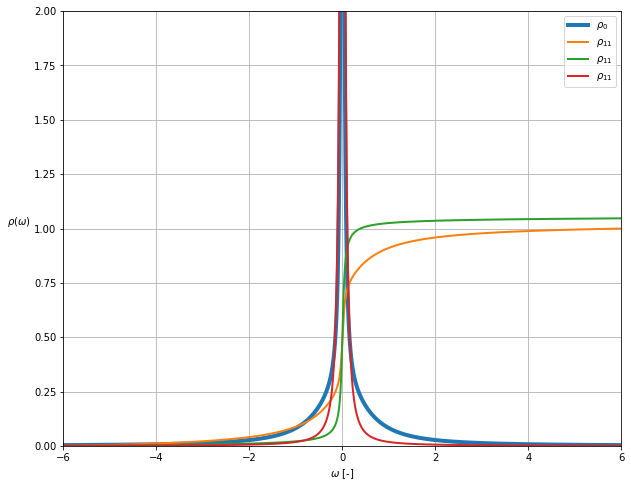

In [3]:
#omega= np.logspace(-10, 1.0, num=1500, base = 6)
#omega=np.concatenate((-np.flip(omega),omega))
#eta=0.02*abs(omega)+0.038
omega= np.linspace(-6,6,3000)
eta=0.02*abs(omega)+0.038
Gamma=0.3
rhoM,intGM,GM,intG,rho=rhoij0(omega, Gamma,eta)
for i in range(2):
    intGM[i][i]=intGM[i][i]/intGM[i][i][-1]
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,rhoM[0][0],label='$\\rho_0$',linewidth=4)
plt.plot(omega,intGM[0][0],linewidth=2,label='$\\rho_{11}$')
plt.plot(omega,intG,linewidth=2,label='$\\rho_{11}$')
plt.plot(omega,rho,linewidth=2,label='$\\rho_{11}$')
plt.legend()

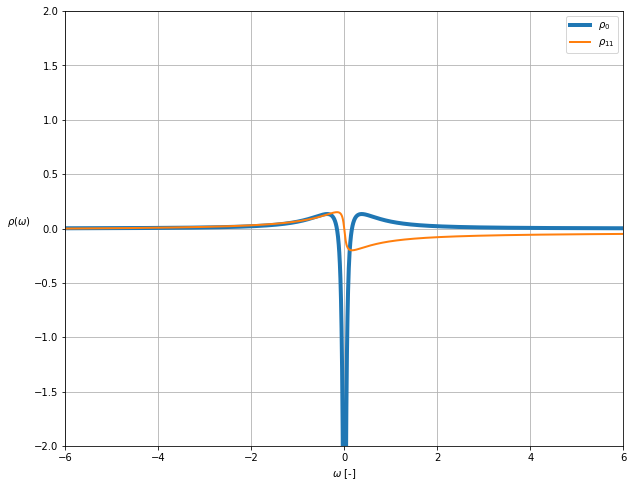

In [4]:
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=-2,top=2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,rhoM[0][1],label='$\\rho_0$',linewidth=4)
plt.plot(omega,intGM[0][1],linewidth=2,label='$\\rho_{11}$')
plt.legend()

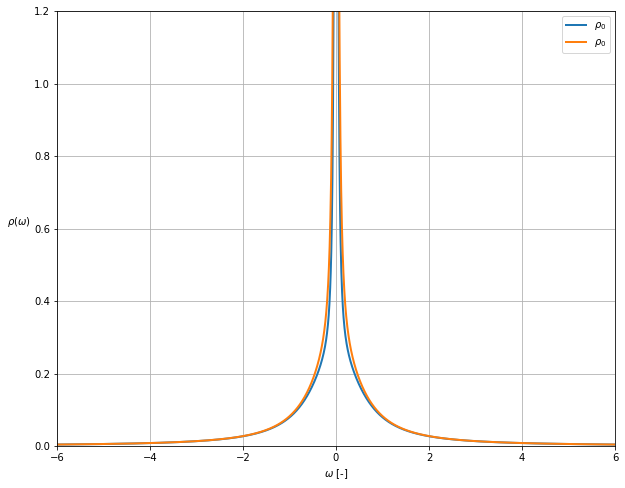

In [5]:
delta=-1.j*Gamma
Gii0=(omega+1.j*Gamma+1.j*eta)/(omega**2+2*omega*Gamma*1.j+2*omega*eta*1.j-eta**2-eta*Gamma)
rhoii0=-np.imag(Gii0)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,rhoii0,label='$\\rho_0$',linewidth=2)
plt.plot(omega,rhoM[0][0],label='$\\rho_0$',linewidth=2)
plt.legend()

In [6]:
N=3003
epsilonk=np.linspace(-6,6,N-2)
Gamma=0.3

t=sqrt((Gamma*12)/(np.pi*N))#1/(N**(Gamma+0.0105))#1/2*0.7
H=np.array(np.full((N,N),np.zeros(N,dtype = 'complex_')))
for i in tqdm(range(2,N)):
    H[i][i]=epsilonk[i-2]
    H[i][0]=H[0][i]=H[1][i]=H[i][1]=t
H=Qobj(H)
E,P=H.eigenstates()

In [7]:
N=3003
N2=3000
#N=10002
omega= np.logspace(-10, 1.0, num=1500, base = 6)
omega=np.concatenate((-np.flip(omega),omega))
G=np.zeros(N2,dtype = 'complex_')
eta=sqrt((Gamma*12)/(np.pi*N))#1/(N**0.435)#Gamma/20#0.02*abs(omega)+Gamma
for i in range(N):
    G+=abs(P[i][0][0][0])**2/(omega+eta*1j-E[i])
psi=[[],[]]
for j in range(len(psi)):
    for i in range(len(P)):
        psi[j].append(abs(P[i][j][0][0])**2)
    psi[j]=psi[j]/sum(psi[j])
print(sum(psi[0]),sum(psi[1]))
print(len(E))

1.0000000000000002 1.0
3003


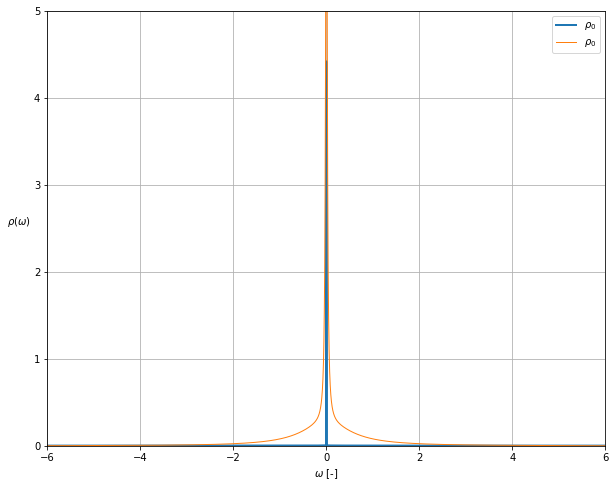

In [8]:
for i in range(5):
    for j in range(2,len(G)-2):
        G[j]=(G[j-2]+G[j-1]+G[j]+G[j+1]+G[j+2])/5
rho=-np.imag(G)/np.pi

plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=5)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,rhoM[0][0],label='$\\rho_0$',linewidth=2)
plt.plot(omega,rho,label='$\\rho_0$',linewidth=1)
plt.legend()

In [9]:
Nimpurities=2
poles=4
posimp=np.full(Nimpurities,int(0))
nimpurities=np.full(Nimpurities,int(poles/Nimpurities))
for i in range(1,len(posimp)):
    posimp[i]=int(2*nimpurities[i-1])
N=10000
selected=[[],[]]
indexs=[]
for i in range(len(P)):
    indexs.append(i)
selected2=[]
for i in tqdm(range(N)):
    select,index=sampler(poles,intGM,posimp,omega)
    indexselect=sorted(np.random.choice(indexs, poles,p=psi[0]))
    select2=E[indexselect]
    for j in range(poles):
        selected2.append(select2[j])
    for j in range(poles):
        for k in range(Nimpurities):
            selected[k].append(select[k][j])

bar=1000
x=np.linspace(min(omega),max(omega),bar)
x2=np.linspace(min(omega),max(omega),bar-1)
y=[[],[]]
y2=[]
for i in range(0,bar-1):
    for k in range(len(selected)):
        y[k].append(((x[i] < selected[k]) & (selected[k] <= x[i+1])).sum())
    y2.append(((x[i] < selected2) & (selected2 <= x[i+1])).sum())
for k in range(len(selected)):
    y[k]=y[k]/(12/(bar-1)*sum(y[k]))
y2=y2/(12/(bar-1)*sum(y2))
#for j in range(2,len(y[0])-2):
#    for i in range(len(y)):
#        y[i][j]=(y[i][j-2]+y[i][j-1]+y[i][j]+y[i][j+1]+y[i][j+2])/5
#for i in range(5):
#    for j in range(2,len(y2)-2):
 #       y2[j]=(y2[j-2]+y2[j-1]+y2[j]+y2[j+1]+y2[j+2])/5

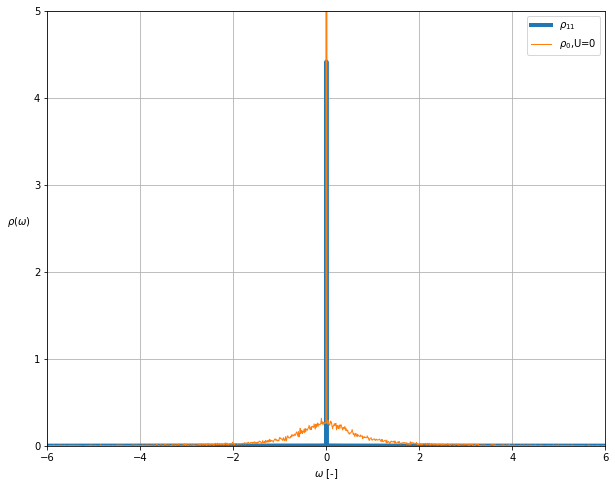

In [10]:
#for i in range(5):
#    for j in range(2,len(y2)-2):
#        y2[j]=(y2[j-2]+y2[j-1]+y2[j]+y2[j+1]+y2[j+2])/5
plt.figure(figsize=(10,8))
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=5)
plt.plot(omega,rhoM[0][0],linewidth=4,label='$\\rho_{11}$')
plt.plot(x2,y2,linewidth=1,label='$\\rho_0$,U=0')
plt.legend()
plt.grid(b='on')

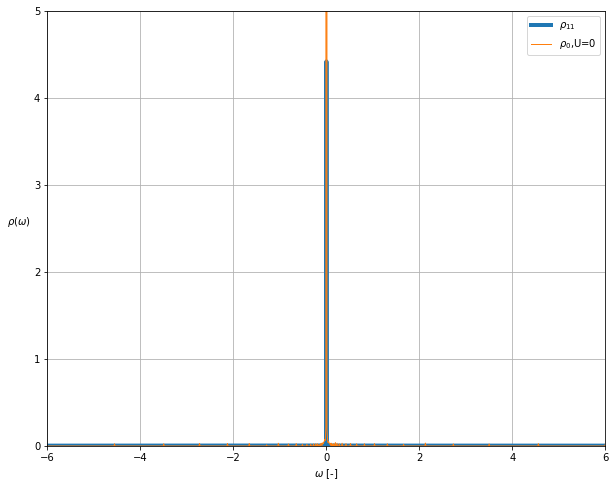

In [11]:
plt.figure(figsize=(10,8))
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=5)
plt.plot(omega,rhoM[0][0],linewidth=4,label='$\\rho_{11}$')
plt.plot(x2,y[0],linewidth=1,label='$\\rho_0$,U=0')
plt.legend()
plt.grid(b='on')

In [12]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

def multiimpPcal(ratio,poles):
    di=np.full((poles+1, poles), np.zeros(poles))
    for i in range(poles):
        di[0][i]=ratio/sqrt(poles*(ratio**2+1))#ratio[i]
        di[1][i]=1/sqrt(poles*(ratio**2+1))#ratio[i]
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i+2][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i+2][i]=sqrt(poles-i-1)/sqrt(poles-i)
    #vec=np.full(poles+1,1/sqrt(poles+1))
    #for i in range(len(di)-1):
    #    vec=vec-np.dot(vec,di[:,i])*di[:,i]
    #normvec=vec/np.linalg.norm(vec)
    #di[:,poles]=normvec
    return di

def multiimpDPgen(ratio,poles,select):
    Pbath =np.array(multiimpPcal(ratio,poles))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    #Dbath[poles][poles]=10000000000000
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def multiimpstartrans(ham_mat,posimp):
    ham_mat2=copy.deepcopy(ham_mat)
    for row in range(len(posimp)):
        ham_mat=np.delete(np.delete(ham_mat,0,axis=0),0,axis=1)
    eigkk,pbar=np.linalg.eig(ham_mat)
    for row in range(len(posimp)):
        pbar=np.insert(np.insert(pbar, 0,0,axis=0),0,0,axis=1)
        pbar[0][0]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat2,pbar))
    return Hp

def HamiltonianAIM(c, impint, bathenergy, Vkk, U,Sigma,posimp,n,J,impn,crossn,bathn,Un,Sigman):
    H = 0
    for k in range(len(impint)):
        H += impint[k] * impn[k]
        for j in range(len(bathenergy[k])):
            H += bathenergy[k][j] * bathn[k][j]
            for l in range(len(Vkk[k])):
                H += Vkk[k][l][j] *crossn[k][l][j]
    error=False
    try:
        #eigs=np.linalg.eigh(H.full())
        eigs=H.eigenstates()
        for i in range(len(eigs[1])):
            eigs[1][i]=eigs[1][i].full()
        exp= np.vdot(eigs[1][0], np.dot(n.full(), eigs[1][0]))
    except np.linalg.LinAlgError:
        error=True
        exp=0
        eigs=0
    except ValueError:
        error=True
        exp=0
        eigs=0
    H += U * Un
    H += -Sigma[0][0] * Sigman
    return H,exp,error,eigs

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(SziSzj,SiSj,impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset,nimp,posimp,n,J,impn,crossn,bathn,Un,Sigman):
    print("--- %s s first part %d---" % ((time.time() - start_time) ,attempts), end='\r')
    H,exp2,error,eigs2= HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma,posimp,n,J,impn,crossn,bathn,Un,Sigman)
    MBG=np.zeros((len(omega),2,2),dtype=np.complex128)
    NIG=np.zeros((len(omega),2,2),dtype=np.complex128)
    expimp=[0,0]
    try:
        eigs=H.eigenstates()
    except np.linalg.LinAlgError:
        error=True
    except ValueError:
        error=True
    if not error:
        for i in range(len(eigs[1])):
            eigs[1][i]=eigs[1][i].full()
        exp= np.vdot(eigs[1][0], np.dot(n.full(), eigs[1][0]))
        #print(np.round(exp),np.round(exp2))
        if np.round(exp)==np.round(exp2):
            reset=True
        SiSjexp=[0,0,np.vdot(eigs[1][0], np.dot(SiSj[0].full()+SiSj[1].full(), eigs[1][0]))]
        SziSzjexp=[0,0,np.vdot(eigs[1][0], np.dot(SziSzj[0].full()+SziSzj[1].full(), eigs[1][0]))]
        if reset:
            print("--- %s s second part %d---" % ((time.time() - start_time) ,attempts), end='\r')
            MBG = MBGAIM(omega, eigs, c, eta,posimp)
            NIG = MBGAIM(omega, eigs2, c, eta,posimp)
            print("--- %s s third part %d---" % ((time.time() - start_time) ,attempts), end='\r')
            for i in range(len(posimp)):
                SiSjexp[i]= np.vdot(eigs[1][0], np.dot(SiSj[i].full(), eigs[1][0]))
                SziSzjexp[i]= np.vdot(eigs[1][0], np.dot(SziSzj[i].full(), eigs[1][0]))
        for i in range(len(posimp)):
            expimp[i]= np.vdot(eigs[1][0], np.dot(nimp[i].full(), eigs[1][0]))
        return MBG,reset,NIG,SiSjexp,SziSzjexp,expimp
    else:
        return MBG,reset,NIG,[0,0,0],[0,0,0],expimp

def MBGAIM(omega, eigs, c, eta,posimp):
    MBG = np.zeros((len(omega),2,2),dtype=np.complex128)
    for j in range(len(posimp)):
        for m in range(len(posimp)):
            for i in range(1, len(eigs[0])):
                exp=np.vdot(eigs[1][i],np.dot(c[posimp[m]].full() ,eigs[1][0]))#m
                exp2=np.vdot(eigs[1][0],np.dot(c[posimp[j]].dag().full() ,eigs[1][i]))#j
                exp3=np.vdot(eigs[1][i],np.dot(c[posimp[j]].dag().full() ,eigs[1][0]))
                exp4=np.vdot(eigs[1][0],np.dot(c[posimp[m]].full() ,eigs[1][i]))
                k=exp*exp2
                l=exp3*exp4
                MBG[:,m,j]+=k/(omega+eigs[0][i]-eigs[0][0]+1.j*eta)+l/(omega+eigs[0][0]-eigs[0][i]+1.j*eta)
    return MBG

def find_nearest2(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def op(c,poles):
    impn=[]
    crossn=[[[],[]],[[],[]]]
    bathn=[[],[]]
    for k in range(Nimpurities):
        impc=0
        for i in range(2):
            impc += (c[posimp[k]+i].dag() * c[posimp[k]+i])
        impn.append(impc)
        for j in range(int(poles/Nimpurities)-1):
            bathc=0
            for i in range(2):
                bathc+= (c[2 * j + i + 2+posimp[k]].dag() * c[2 * j + i + 2+posimp[k]])
            bathn[k].append(bathc)
        for l in range(Nimpurities):
            crossc=0
            for i in range(2):
                crossc+=(c[posimp[k]+i].dag() * c[posimp[l]+i+2+2*j] +c[posimp[l]+i+2+2*j].dag() * c[posimp[k]+i]) 
            crossn[k][l].append(crossc)
    Un=0
    Sigman=0
    SiSj=[0,0]
    SziSzj=[0,0]
    for k in range(Nimpurities):
        Un += (c[posimp[k]].dag() * c[posimp[k]] * c[posimp[k]+1].dag() * c[posimp[k]+1])
        Sigman += (c[posimp[k]].dag() * c[posimp[k]] + c[posimp[k]+1].dag() * c[posimp[k]+1])
        for l in range(Nimpurities):
            if k !=l:
                SiSj[k]=(1/2*(c[posimp[k]].dag()*c[posimp[k]+1]*c[posimp[l]+1].dag()*
                    c[posimp[l]]+c[posimp[k]+1].dag()*c[posimp[k]]*c[posimp[l]].dag()*
                            c[posimp[l]+1])+1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*
                                                 c[posimp[k]+1])*(c[posimp[l]].dag()*
                                                                 c[posimp[l]]-c[posimp[l]+1].dag()*
                                                                 c[posimp[l]+1]))
                SziSzj[k]=1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*
                            c[posimp[k]+1])*(c[posimp[l]].dag()*
                                             c[posimp[l]]-c[posimp[l]+1].dag()*
                                             c[posimp[l]+1])
    return impn,crossn,bathn,Un,Sigman,SiSj,SziSzj

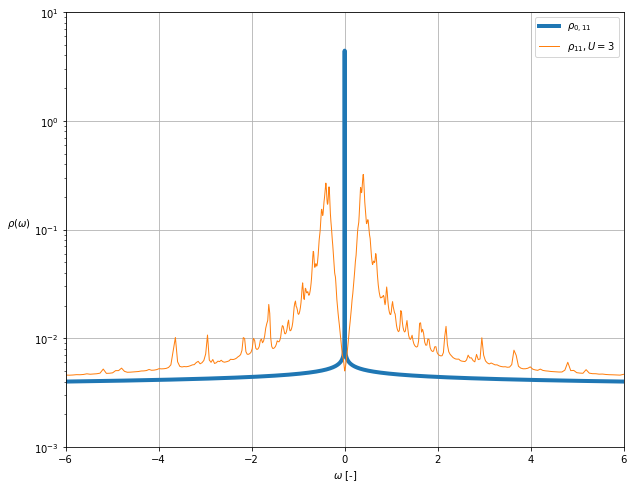

--- 0.7399823665618896 s first part 3-----


KeyboardInterrupt: 

In [13]:
U=[3]#
J=[0]#
lattice_length = 2*poles
selected=[[[],[]],[[],[]]]
c = []
for i in range(lattice_length):
    c.append(jordan_wigner_transform(i, lattice_length))
nc=0
for i in range(len(c)):
    nc+=c[i].dag()*c[i]
impn,crossn,bathn,Un,Sigman,SiSj,SziSzj=op(c,poles)
nimp=[0,0]
for i in range(len(nimp)):
    for j in range(2*nimpurities[i]):
        nimp[i]+=c[j+posimp[i]].dag()*c[j+posimp[i]]
polest=[[]]
N=20000
FinSigmadat=[]
SiSjdat=[]
SziSzjdat=[]
expdat=[]
#eta=0.02*abs(omega)
for m in range(len(J)):
    SiSjtot=[0,0,0]
    SziSzjtot=[0,0,0]
    exptot=[0,0]
    Sigma=[[U[m]/2,0],[0,U[m]/2]]
    AvgSigmadat=np.zeros((len(omega),2,2),dtype=np.complex128)
    for i in tqdm(range(N)):
        start_time = time.time()
        attempts=0
        reset=False
        while not reset:
            #select,index=sampler(nimpurities[0],intGM,posimp,omega)
            select,index=sampler(int(poles/Nimpurities),intGM,posimp,omega)
            indexselect=index[0]
            #print(indexselect,select[0])
            indexselect=[find_nearest2(E, x) for x in select[0]]
            #print(indexselect,select[0])
            #indexselect=sorted(np.random.choice(indexs, int(poles/Nimpurities),p=psi[0]))
            indexselect=[x for item in indexselect for x in repeat(item, Nimpurities)]
            indexselect[1], indexselect[2] = indexselect[2], indexselect[1]
            #indexselect=[x+2 for x in indexselect]
            select2=E[indexselect]
            #print(select2)
            #print(select2)
            #ratio=[]
            #for k in range(len(indexselect)):
            #    ratio.append(P[indexselect[k]][0][0][0]/P[indexselect[k]][1][0][0])
            ratioimp1=0
            ratioimp2=0
            for k in range(len(indexselect)):
                ratioimp1+=psi[0][indexselect[k]]
                ratioimp2+=psi[1][indexselect[k]]
            ratio=sqrt(ratioimp1/ratioimp2)
            NewM=multiimpstartrans(multiimpDPgen(ratio,poles,select2),[0,1]) 
            #print(NewM)
            bathenergy=[[],[]]
            Vkk=[[[],[]],[[],[]]]
            impenergy=[NewM[0][0],NewM[1][1]]
            for k in range(len(bathenergy)):
                for j in range(int(poles/2-1)):
                    bathenergy[k].append((NewM[k+2+2*j][k+2+2*j]+NewM[k+3+2*j][k+3+2*j])/2)
                    for l in range(len(impenergy)):
                        Vkk[l][k].append((NewM[l][k+2+2*j]+NewM[l][k+3+2*j])/2)
            #print(impenergy,bathenergy,Vkk)
            MBGdat,reset,NIG,SiSjexp,SziSzjexp,exp=AIMsolver(SziSzj,SiSj,impenergy, bathenergy, Vkk, U[m], Sigma, omega, eta, c,reset,nimp,posimp,nc,J[m],impn,crossn,bathn,Un,Sigman)
            attempts+=1
            NewSigmadat=np.zeros((len(omega),2,2),dtype=np.complex128)
            if reset:
                try:
                    NewSigmadat+=np.linalg.pinv(NIG)-np.linalg.pinv(MBGdat)
                    NewSigmadat+=Sigma
                except np.linalg.LinAlgError:
                    reset=False
            if np.isnan(NewSigmadat).any() or any(i >= 1000 for i in np.real(NewSigmadat[0][0])):
                reset=False
        print("--- %s s 4rd part %d---" % ((time.time() - start_time) ,attempts), end='\r')
        for j in range(len(select2)):
            polest[0].append(select2[j])
        AvgSigmadat=AvgSigmadat+NewSigmadat
        SiSjtot+=[float(i)/N for i in SiSjexp]
        SziSzjtot+=[float(i)/N for i in SziSzjexp]
        exptot+=[float(i)/N for i in exp]
        
        dDosT=[]
        for m in range(len(J)):
            fDos=np.full((len(posimp),len(posimp),len(omega)), np.full((len(posimp), len(omega)), np.zeros(len(omega),dtype = 'complex_')))
            Sigmadat=AvgSigmadat
            print(Sigmadat[1500,:,:])
            for j in range(len(omega)):
                FinSigmadat2=np.linalg.pinv(np.linalg.pinv(GM[:,:,j])-Sigmadat[j,:,:]/(i+1)+[[U[m]/2,0],[0,U[m]/2]])
                fDos[:,:,j]=-np.imag(FinSigmadat2)/np.pi
            dDosT.append(fDos)
        clear_output(wait=True)
        plt.figure(figsize=(10,8))
        plt.xlim(min(omega), max(omega))
        plt.gca().set_ylim(bottom=0.001,top=10)
        plt.yscale("log")
        plt.xlabel("$\\omega$ [-]")
        plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
        plt.plot(omega,rhoM[0][0],label='$\\rho_{0,11}$',linewidth=4)
        #plt.plot(omega,intGM[0][0],linewidth=3,label='$\\rho_{11}$')
        for i in range(len(J)):
            plt.plot(omega,dDosT[i][0][0],linewidth=1,label='$\\rho_{11},U= %.0f$'%U[i])
        plt.legend()
        plt.grid(b='on')
        plt.show()
        
    SiSjtot1=[0,0,0]
    SziSzjtot1=[0,0,0]
    exptot1=[0,0]
    for j in range(len(SziSzjtot1)):
        for i in range(int(len(SziSzjtot)/3)):
            SziSzjtot1[j]+=SziSzjtot[3*i+j]
    for j in range(len(SiSjtot1)):
        for i in range(int(len(SiSjtot)/3)):
            SiSjtot1[j]+=SiSjtot[3*i+j]
    for j in range(len(exptot1)):
        for i in range(int(len(exptot)/2)):
            exptot1[j]+=exptot[2*i+j]
    print(SiSjtot1,exptot1,SziSzjtot1)
    FinSigmadat.append(AvgSigmadat)
    SiSjdat.append(SiSjtot1)
    SziSzjdat.append(SziSzjtot1)
    expdat.append(exptot1)
#[-0.6581416462030475, -0.6581416462030475, -1.316283292406095] [2.0001538621915333, 2.002846137808471]

In [ ]:
dDosT=[]
#print(SiSjdat,expdat)
#print(Gnonint[0,:,:],Gnonint[-1,:,:],FinSigmadat[0][:,:,0],FinSigmadat[0][:,:,-1])
for m in range(len(J)):
    fDos=np.full((len(posimp),len(posimp),len(omega)), np.full((len(posimp), len(omega)), np.zeros(len(omega),dtype = 'complex_')))
    Sigmadat=FinSigmadat[m]
    print(Sigmadat[1500,:,:])
    for j in range(len(omega)):
        FinSigmadat2=np.linalg.pinv(np.linalg.pinv(GM[:,:,j])-Sigmadat[j,:,:]+[[U[m]/2,0],[0,U[m]/2]])
        fDos[:,:,j]=-np.imag(FinSigmadat2)/np.pi
    dDosT.append(fDos)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0.001,top=10)
plt.yscale("log")
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,rhoM[0][0],label='$\\rho_{0,11}$',linewidth=4)
#plt.plot(omega,intGM[0][0],linewidth=3,label='$\\rho_{11}$')
J=[-3,-6,-9,-12]
for i in range(len(J)):
    plt.plot(omega,dDosT[i][0][0],linewidth=1,label='$\\rho_{11},U= %.0f$'%U[i])
plt.legend()

In [ ]:
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=-0.2,top=0.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,rhoM[0][1],label='$\\rho_{0,12}$',linewidth=4)
#plt.plot(omega,intGM[0][0],linewidth=3,label='$\\rho_{11}$')
J=[-3,-6,-9,-12]
for i in range(len(J)):
    plt.plot(omega,dDosT[i][0][1],linewidth=1,label='$\\rho_{12},U= %.0f$'%U[i])
plt.legend()

In [ ]:
dDosT2=[]
for m in range(len(J)):
    fDos=np.full((len(posimp),len(posimp),len(omega)), np.full((len(posimp), len(omega)), np.zeros(len(omega),dtype = 'complex_')))
    Sigmadat=FinSigmadat[m]
    print(Sigmadat[1500,:,:])
    for j in range(len(omega)):
        FinSigmadat2=np.linalg.pinv(np.linalg.pinv(GM[:,:,j])-Sigmadat[j,:,:]+[[U[m]/2,0],[0,U[m]/2]])
        fDos[:,:,j]=abs(FinSigmadat2)
    dDosT2.append(fDos)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0.0001,top=100)
plt.yscale("log")
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid(b='on')
plt.plot(omega,abs(GM[0][1]),label='$\\rho_{0,12}$',linewidth=4)
#plt.plot(omega,intGM[0][0],linewidth=3,label='$\\rho_{11}$')
J=[-3,-6,-9,-12]
for i in range(len(J)):
    plt.plot(omega,dDosT2[i][0][1],linewidth=1,label='$|G_{12}|, U= %.0f$'%U[i])
plt.legend()